In [22]:
!git clone https://github.com/IvanWoelffel/nanoGPT.git

Cloning into 'nanoGPT'...
remote: Enumerating objects: 711, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 711 (delta 3), reused 21 (delta 3), pack-reused 689 (from 1)
Receiving objects: 100% (711/711), 5.80 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (385/385), done.


In [23]:
!ls


AGENTS.md	 LICENSE	     test.ipynb
assets		 model.py	     test_wikitext2_bookcorpus.ipynb
bench.py	 nanoGPT	     train.py
config		 __pycache__	     transformer_sizing.ipynb
configurator.py  README.md	     wikitext2_vs_bookcorpus_comparison.png
data		 sample.py
doc		 scaling_laws.ipynb


In [24]:
%cd nanoGPT
!pip install tiktoken seaborn

/content/nanoGPT/nanoGPT


# Nano-GPT: WikiText-2 vs BookCorpus Comparison

This notebook compares training Nano-GPT on two datasets with different text styles:
- **WikiText-2**: Encyclopedic text from Wikipedia
- **BookCorpus**: Narrative text from books (sampled subset)

**Objectives:**
1. Compare training curves and convergence
2. Analyze final perplexities
3. Compare text generation quality
4. Study token distribution differences

**Time estimate**: ~30 minutes on GPU

In [25]:
import torch
import torch.nn as nn
import numpy as np
from model import GPT, GPTConfig
import tiktoken
from contextlib import nullcontext
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
from tqdm.auto import tqdm

torch.manual_seed(1337)
np.random.seed(1337)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete. Libraries imported.")

Setup complete. Libraries imported.


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_bf16_supported() else 'float16'

batch_size = 12
block_size = 256
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.1
learning_rate = 1e-3
max_iters = 3000
eval_interval = 200
eval_iters = 100
warmup_iters = 100
min_lr = 1e-4
weight_decay = 0.1
beta1 = 0.9
beta2 = 0.99
grad_clip = 1.0
decay_lr = True
TARGET_TOKENS = 2_500_000

print(f"Device: {device}, Dtype: {dtype}")
print(f"Model: {n_layer} layers, {n_head} heads, {n_embd} dim")
print(f"Training: {max_iters} iters, batch_size={batch_size}, block_size={block_size}")
print(f"BookCorpus target: {TARGET_TOKENS:,} tokens")

Device: cuda, Dtype: bfloat16
Model: 6 layers, 6 heads, 384 dim
Training: 3000 iters, batch_size=12, block_size=256
BookCorpus target: 2,500,000 tokens


In [27]:
def prepare_wikitext2():
    train_path = 'data/wikitext2/train.bin'
    val_path = 'data/wikitext2/val.bin'

    if os.path.exists(train_path) and os.path.exists(val_path):
        print(" WikiText-2 already prepared")
        return

    print("Preparing WikiText-2 dataset...")
    from datasets import load_dataset

    enc = tiktoken.get_encoding("gpt2")
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

    for split, split_name in [('train', 'train'), ('validation', 'val')]:
        all_ids = []
        for example in tqdm(dataset[split], desc=f"Tokenizing {split}"):
            if example['text'].strip():
                ids = enc.encode_ordinary(example['text'])
                ids.append(enc.eot_token)
                all_ids.extend(ids)

        arr = np.array(all_ids, dtype=np.uint16)
        os.makedirs('data/wikitext2', exist_ok=True)
        arr.tofile(f'data/wikitext2/{split_name}.bin')
        print(f"  {split_name}: {len(arr):,} tokens ({len(arr)*2/1024/1024:.2f} MB)")

    print(" WikiText-2 preparation complete")


def prepare_bookcorpus_sample(target_tokens=TARGET_TOKENS):
    train_path = 'data/bookcorpus/train_sample.bin'
    val_path = 'data/bookcorpus/val_sample.bin'

    if os.path.exists(train_path) and os.path.exists(val_path):
        train_data = np.memmap(train_path, dtype=np.uint16, mode='r')
        if len(train_data) >= target_tokens * 0.9:
            print(f" BookCorpus sample already prepared ({len(train_data):,} tokens)")
            return

    print(f"Preparing BookCorpus sample (target ~{target_tokens:,} tokens)...")
    from datasets import load_dataset

    enc = tiktoken.get_encoding("gpt2")
    val_ratio = 0.1

    dataset = load_dataset("SamuelYang/bookcorpus", split="train", streaming=True)

    train_ids = []
    val_ids = []

    for i, example in enumerate(tqdm(dataset, desc="Tokenizing BookCorpus")):
        if len(train_ids) >= target_tokens:
            break

        text = example['text']
        if text.strip():
            ids = enc.encode_ordinary(text)
            ids.append(enc.eot_token)

            if np.random.random() < val_ratio:
                val_ids.extend(ids)
            else:
                train_ids.extend(ids)

    os.makedirs('data/bookcorpus', exist_ok=True)

    train_arr = np.array(train_ids[:target_tokens], dtype=np.uint16)
    train_arr.tofile(train_path)
    print(f"  train_sample: {len(train_arr):,} tokens ({len(train_arr)*2/1024/1024:.2f} MB)")

    val_arr = np.array(val_ids[:int(target_tokens*val_ratio)], dtype=np.uint16)
    val_arr.tofile(val_path)
    print(f"  val_sample: {len(val_arr):,} tokens ({len(val_arr)*2/1024/1024:.2f} MB)")

    print(" BookCorpus sample preparation complete")

print("Dataset preparation functions defined!")

Dataset preparation functions defined!


In [28]:
print("Preparing datasets...")
prepare_wikitext2()
prepare_bookcorpus_sample()

print("\nLoading datasets...")

wikitext2_train = np.memmap('data/wikitext2/train.bin', dtype=np.uint16, mode='r')
wikitext2_val = np.memmap('data/wikitext2/val.bin', dtype=np.uint16, mode='r')

bookcorpus_train = np.memmap('data/bookcorpus/train_sample.bin', dtype=np.uint16, mode='r')
bookcorpus_val = np.memmap('data/bookcorpus/val_sample.bin', dtype=np.uint16, mode='r')

print(f"\n{'='*60}")
print("DATASET STATISTICS")
print(f"{'='*60}")

print(f"\nWikiText-2 (Encyclopedic):")
print(f"  Train: {len(wikitext2_train):,} tokens ({len(wikitext2_train)*2/1024/1024:.2f} MB)")
print(f"  Val:   {len(wikitext2_val):,} tokens ({len(wikitext2_val)*2/1024/1024:.2f} MB)")

print(f"\nBookCorpus (Narrative - Sampled):")
print(f"  Train: {len(bookcorpus_train):,} tokens ({len(bookcorpus_train)*2/1024/1024:.2f} MB)")
print(f"  Val:   {len(bookcorpus_val):,} tokens ({len(bookcorpus_val)*2/1024/1024:.2f} MB)")

print(f"\nComparison:")
print(f"  WikiText-2 / BookCorpus ratio: {len(wikitext2_train)/len(bookcorpus_train):.2f}x")
print(f"  Difference: {abs(len(wikitext2_train) - len(bookcorpus_train)):,} tokens")

print(f"\n{'='*60}")
print("Datasets loaded successfully!")
print(f"{'='*60}")

Preparing datasets...
Preparing WikiText-2 dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Tokenizing train:   0%|          | 0/36718 [00:00<?, ?it/s]

  train: 2,415,651 tokens (4.61 MB)


Tokenizing validation:   0%|          | 0/3760 [00:00<?, ?it/s]

  val: 249,750 tokens (0.48 MB)
✓ WikiText-2 preparation complete
Preparing BookCorpus sample (target ~2,500,000 tokens)...


Tokenizing BookCorpus: 0it [00:00, ?it/s]

  train_sample: 2,500,000 tokens (4.77 MB)
  val_sample: 250,000 tokens (0.48 MB)
✓ BookCorpus sample preparation complete

Loading datasets...

DATASET STATISTICS

WikiText-2 (Encyclopedic):
  Train: 2,415,651 tokens (4.61 MB)
  Val:   249,750 tokens (0.48 MB)

BookCorpus (Narrative - Sampled):
  Train: 2,500,000 tokens (4.77 MB)
  Val:   250,000 tokens (0.48 MB)

Comparison:
  WikiText-2 / BookCorpus ratio: 0.97x
  Difference: 84,349 tokens

Datasets loaded successfully!


In [29]:
def create_model(vocab_size=50257):
    config = GPTConfig(
        vocab_size=vocab_size,
        block_size=block_size,
        n_layer=n_layer,
        n_head=n_head,
        n_embd=n_embd,
        dropout=dropout,
        bias=True,
    )
    return GPT(config)

print("Creating models...")
model_wikitext = create_model()
model_bookcorpus = create_model()

num_params = model_wikitext.get_num_params()

print(f"  WikiText-2 model: {num_params/1e6:.2f}M parameters")
print(f"  BookCorpus model: {num_params/1e6:.2f}M parameters")
print(f"  Architecture: {n_layer} layers, {n_head} heads, {n_embd} dimensions")

print("\n" + "="*70)
print("Models created successfully!")
print("="*70)

Creating models...
number of parameters: 29.95M
number of parameters: 29.95M
  WikiText-2 model: 29.95M parameters
  BookCorpus model: 29.95M parameters
  Architecture: 6 layers, 6 heads, 384 dimensions

Models created successfully!


In [30]:
def get_batch(data, batch_size, block_size, device):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss(model, train_data, val_data, batch_size, block_size, eval_iters, device, dtype_ctx):
    model.eval()
    losses = {}

    for split, data in [('train', train_data), ('val', val_data)]:
        loss_list = []
        for _ in range(eval_iters):
            X, Y = get_batch(data, batch_size, block_size, device)
            with dtype_ctx:
                _, loss = model(X, Y)
            loss_list.append(loss.item())
        losses[split] = np.mean(loss_list)

    model.train()
    return losses

def get_lr(iter_num, warmup_iters, lr_decay_iters, learning_rate, min_lr):
    if iter_num < warmup_iters:
        return learning_rate * (iter_num + 1) / (warmup_iters + 1)
    if iter_num > lr_decay_iters:
        return min_lr
    decay_ratio = (iter_num - warmup_iters) / (lr_decay_iters - warmup_iters)
    coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

def train_model(model, train_data, val_data, max_iters, learning_rate, out_dir, dataset_name):
    model = model.to(device)
    model.train()

    optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device)
    scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

    dtype_torch = torch.bfloat16 if 'bfloat' in dtype else torch.float16
    if device == 'cuda':
        dtype_ctx = torch.amp.autocast(device_type=device, dtype=dtype_torch)
    else:
        dtype_ctx = nullcontext()

    history = {'train_loss': [], 'val_loss': [], 'lr': [], 'iter': [], 'time': []}
    os.makedirs(out_dir, exist_ok=True)

    print(f"\n{'='*60}")
    print(f"Training on {dataset_name}")
    print(f"{'='*60}")
    print(f"  Max iterations: {max_iters}")
    print(f"  Learning rate: {learning_rate}")
    print(f"  Parameters: {model.get_num_params()/1e6:.2f}M")
    print(f"  Train tokens: {len(train_data):,}")
    print(f"{'='*60}")

    t0 = time.time()
    best_val_loss = float('inf')

    for iter_num in range(max_iters):
        lr = get_lr(iter_num, warmup_iters, max_iters, learning_rate, min_lr) if decay_lr else learning_rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        X, Y = get_batch(train_data, batch_size, block_size, device)

        with dtype_ctx:
            _, loss = model(X, Y)

        scaler.scale(loss).backward()
        if grad_clip != 0.0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        if iter_num % eval_interval == 0 or iter_num == max_iters - 1:
            t1 = time.time()
            losses = estimate_loss(model, train_data, val_data, batch_size, block_size, eval_iters, device, dtype_ctx)
            dt = t1 - t0
            tokens_per_sec = batch_size * block_size * eval_interval / dt

            print(f"  Iter {iter_num:4d}/{max_iters}: train={losses['train']:.4f}, val={losses['val']:.4f}, lr={lr:.6f}, {tokens_per_sec:.0f} tok/s")

            history['train_loss'].append(losses['train'])
            history['val_loss'].append(losses['val'])
            history['lr'].append(lr)
            history['iter'].append(iter_num)
            history['time'].append(t1 - t0)

            if losses['val'] < best_val_loss:
                best_val_loss = losses['val']
                checkpoint = {'model': model.state_dict(), 'config': model.config, 'iter_num': iter_num, 'best_val_loss': best_val_loss}
                torch.save(checkpoint, os.path.join(out_dir, 'ckpt.pt'))

            t0 = time.time()

    print(f"\n Training complete on {dataset_name}!")
    print(f"  Best validation loss: {best_val_loss:.4f}")

    return history

print("Training functions defined successfully!")

Training functions defined successfully!


In [31]:
print("="*70)
print("TRAINING ON WIKITEXT-2 (Encyclopedic)")
print("="*70)

history_wikitext = train_model(
    model=model_wikitext,
    train_data=wikitext2_train,
    val_data=wikitext2_val,
    max_iters=max_iters,
    learning_rate=learning_rate,
    out_dir='out-wikitext2-comparison',
    dataset_name='WikiText-2'
)

TRAINING ON WIKITEXT-2 (Encyclopedic)
num decayed parameter tensors: 26, with 30,013,824 parameters
num non-decayed parameter tensors: 50, with 30,720 parameters
using fused AdamW: True

Training on WikiText-2
  Max iterations: 3000
  Learning rate: 0.001
  Parameters: 29.95M
  Train tokens: 2,415,651


/tmp/ipython-input-2946449248.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


  Iter    0/3000: train=10.8297, val=10.8292, lr=0.000010, 560838 tok/s
  Iter  200/3000: train=6.2716, val=6.3900, lr=0.000997, 11505 tok/s
  Iter  400/3000: train=5.8142, val=6.0719, lr=0.000976, 11117 tok/s
  Iter  600/3000: train=5.6018, val=5.9560, lr=0.000936, 11039 tok/s
  Iter  800/3000: train=5.3977, val=5.8369, lr=0.000877, 11015 tok/s
  Iter 1000/3000: train=5.1989, val=5.7103, lr=0.000803, 11051 tok/s
  Iter 1200/3000: train=5.0573, val=5.6634, lr=0.000717, 11038 tok/s
  Iter 1400/3000: train=4.8907, val=5.5480, lr=0.000623, 11031 tok/s
  Iter 1600/3000: train=4.7655, val=5.4897, lr=0.000526, 11030 tok/s
  Iter 1800/3000: train=4.6493, val=5.4158, lr=0.000430, 11026 tok/s
  Iter 2000/3000: train=4.5336, val=5.3578, lr=0.000339, 11025 tok/s
  Iter 2200/3000: train=4.4591, val=5.2736, lr=0.000259, 11017 tok/s
  Iter 2400/3000: train=4.3867, val=5.2883, lr=0.000192, 11014 tok/s
  Iter 2600/3000: train=4.3369, val=5.2446, lr=0.000142, 11053 tok/s
  Iter 2800/3000: train=4.3261,

In [32]:
print("\n" + "="*70)
print("TRAINING ON BOOKCORPUS (Narrative - Sampled)")
print("="*70)

history_bookcorpus = train_model(
    model=model_bookcorpus,
    train_data=bookcorpus_train,
    val_data=bookcorpus_val,
    max_iters=max_iters,
    learning_rate=learning_rate,
    out_dir='out-bookcorpus-comparison',
    dataset_name='BookCorpus'
)


TRAINING ON BOOKCORPUS (Narrative - Sampled)
num decayed parameter tensors: 26, with 30,013,824 parameters
num non-decayed parameter tensors: 50, with 30,720 parameters
using fused AdamW: True

Training on BookCorpus
  Max iterations: 3000
  Learning rate: 0.001
  Parameters: 29.95M
  Train tokens: 2,500,000


/tmp/ipython-input-2946449248.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


  Iter    0/3000: train=10.8102, val=10.8086, lr=0.000010, 15917603 tok/s
  Iter  200/3000: train=5.4553, val=5.5182, lr=0.000997, 11079 tok/s
  Iter  400/3000: train=5.1393, val=5.2244, lr=0.000976, 11075 tok/s
  Iter  600/3000: train=4.9785, val=5.1163, lr=0.000936, 11052 tok/s
  Iter  800/3000: train=4.8421, val=4.9925, lr=0.000877, 11057 tok/s
  Iter 1000/3000: train=4.7076, val=4.9282, lr=0.000803, 11047 tok/s
  Iter 1200/3000: train=4.6369, val=4.8577, lr=0.000717, 11042 tok/s
  Iter 1400/3000: train=4.4930, val=4.7379, lr=0.000623, 11024 tok/s
  Iter 1600/3000: train=4.3956, val=4.6748, lr=0.000526, 11061 tok/s
  Iter 1800/3000: train=4.3089, val=4.6049, lr=0.000430, 11038 tok/s
  Iter 2000/3000: train=4.2282, val=4.5329, lr=0.000339, 11037 tok/s
  Iter 2200/3000: train=4.1744, val=4.4972, lr=0.000259, 11036 tok/s
  Iter 2400/3000: train=4.1434, val=4.4666, lr=0.000192, 11037 tok/s
  Iter 2600/3000: train=4.0757, val=4.4274, lr=0.000142, 11033 tok/s
  Iter 2800/3000: train=4.061

In [33]:
print("="*70)
print("FINAL EVALUATION")
print("="*70)

wiki_train_loss = history_wikitext['train_loss'][-1]
wiki_val_loss = history_wikitext['val_loss'][-1]
wiki_train_ppl = np.exp(wiki_train_loss)
wiki_val_ppl = np.exp(wiki_val_loss)

book_train_loss = history_bookcorpus['train_loss'][-1]
book_val_loss = history_bookcorpus['val_loss'][-1]
book_train_ppl = np.exp(book_train_loss)
book_val_ppl = np.exp(book_val_loss)

print(f"\nWikiText-2 (Encyclopedic):")
print(f"  Train loss:      {wiki_train_loss:.4f}")
print(f"  Val loss:        {wiki_val_loss:.4f}")
print(f"  Train perplexity: {wiki_train_ppl:.2f}")
print(f"  Val perplexity:   {wiki_val_ppl:.2f}")

print(f"\nBookCorpus (Narrative):")
print(f"  Train loss:      {book_train_loss:.4f}")
print(f"  Val loss:        {book_val_loss:.4f}")
print(f"  Train perplexity: {book_train_ppl:.2f}")
print(f"  Val perplexity:   {book_val_ppl:.2f}")

print(f"\n{'='*70}")
print("COMPARISON")
print(f"{'='*70}")
print(f"  Val loss ratio (Wiki/Book):  {wiki_val_loss / book_val_loss:.2f}x")
print(f"  Val PPL ratio (Wiki/Book):   {wiki_val_ppl / book_val_ppl:.2f}x")
print(f"  Loss difference:             {abs(wiki_val_loss - book_val_loss):.4f}")
print(f"  PPL difference:              {abs(wiki_val_ppl - book_val_ppl):.2f}")

print(f"\n{'='*70}")
print("INTERPRETATION")
print(f"{'='*70}")
if wiki_val_ppl < book_val_ppl:
    print("  WikiText-2 (Encyclopedic) achieves lower perplexity:")
    print("    - Possible explanation: More regular, predictable sentence structure")
    print("    - Technical vocabulary may have consistent patterns")
else:
    print("  BookCorpus (Narrative) achieves lower perplexity:")
    print("    - Possible explanation: Repetitive dialogue patterns")
    print("    - Narrative conventions may be easier to model")

wiki_gap = wiki_val_loss - wiki_train_loss
book_gap = book_val_loss - book_train_loss

print(f"\n{'='*70}")
print("OVERFITTING ANALYSIS")
print(f"{'='*70}")
print(f"  WikiText-2 train-val gap: {wiki_gap:.4f}")
print(f"  BookCorpus train-val gap:  {book_gap:.4f}")

if wiki_gap < book_gap:
    print(f"  WikiText-2 shows better generalization (smaller gap)")
else:
    print(f"  BookCorpus shows better generalization (smaller gap)")

FINAL EVALUATION

WikiText-2 (Encyclopedic):
  Train loss:      4.2775
  Val loss:        5.2205
  Train perplexity: 72.06
  Val perplexity:   185.03

BookCorpus (Narrative):
  Train loss:      4.0346
  Val loss:        4.4165
  Train perplexity: 56.52
  Val perplexity:   82.80

COMPARISON
  Val loss ratio (Wiki/Book):  1.18x
  Val PPL ratio (Wiki/Book):   2.23x
  Loss difference:             0.8041
  PPL difference:              102.23

INTERPRETATION
  ✓ BookCorpus (Narrative) achieves lower perplexity:
    → Possible explanation: Repetitive dialogue patterns
    → Narrative conventions may be easier to model

OVERFITTING ANALYSIS
  WikiText-2 train-val gap: 0.9431
  BookCorpus train-val gap:  0.3818
  → BookCorpus shows better generalization (smaller gap)


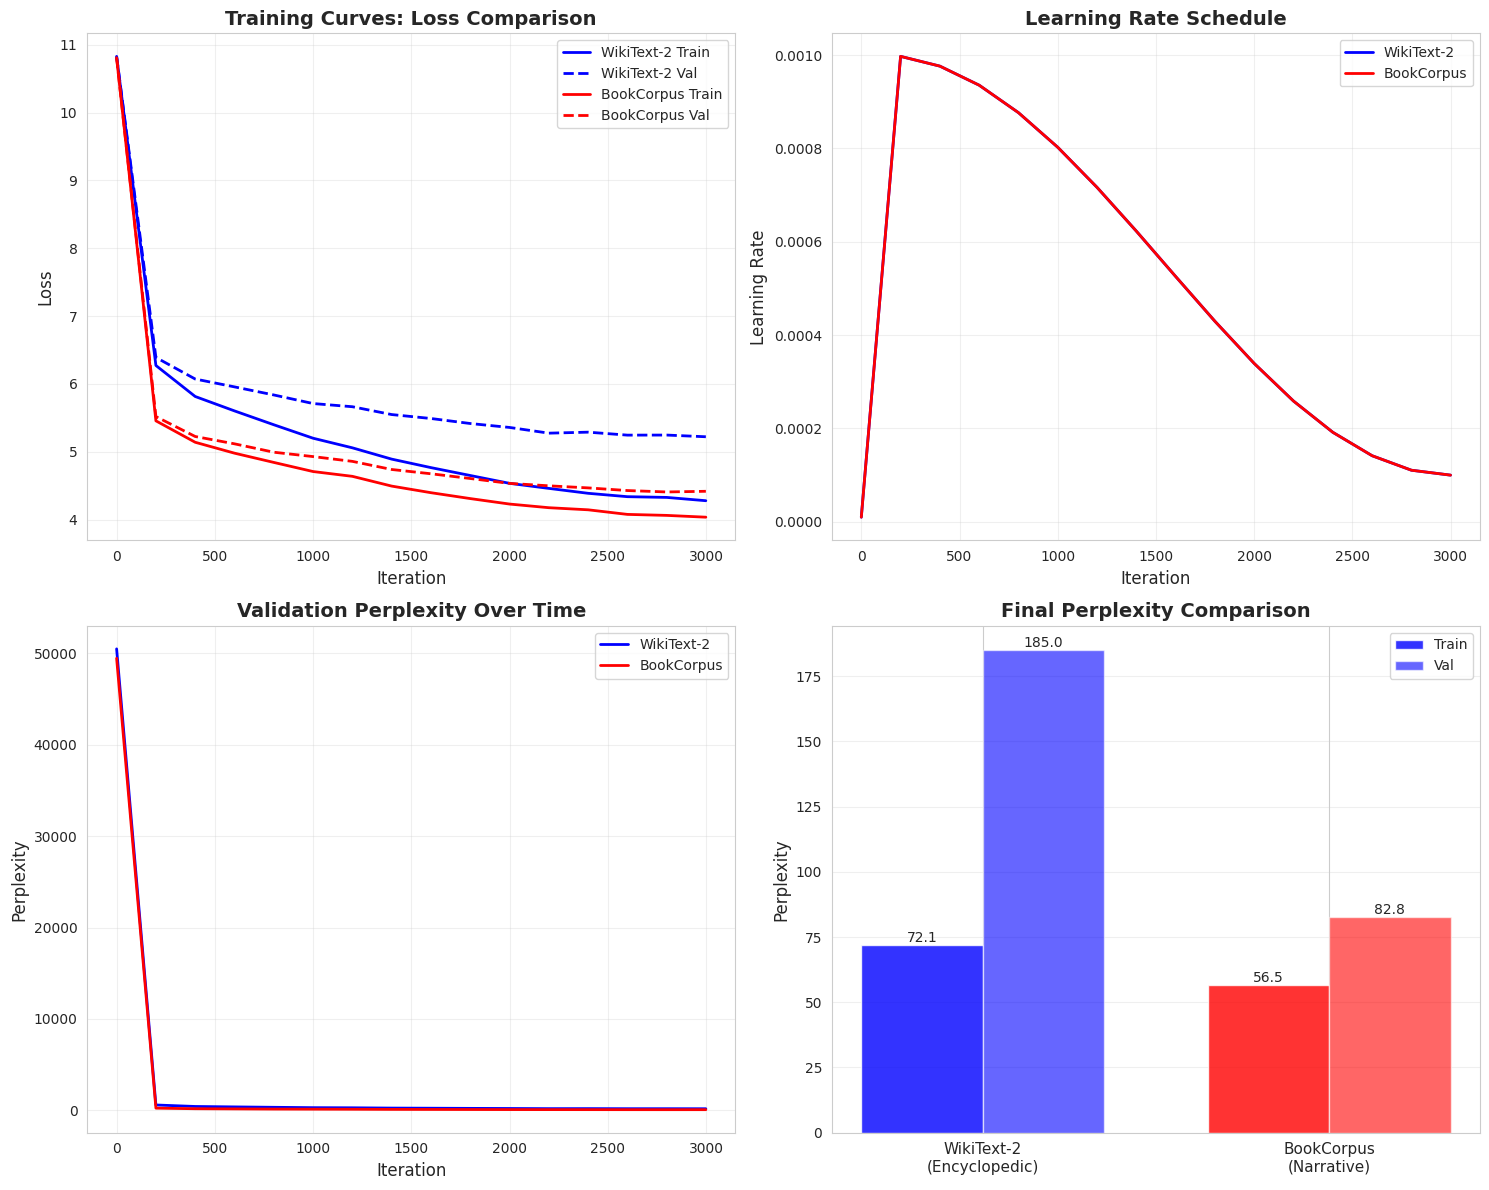

✓ Visualizations saved to 'wikitext2_vs_bookcorpus_comparison.png'


In [34]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(history_wikitext['iter'], history_wikitext['train_loss'], 'b-', label='WikiText-2 Train', linewidth=2)
axes[0, 0].plot(history_wikitext['iter'], history_wikitext['val_loss'], 'b--', label='WikiText-2 Val', linewidth=2)
axes[0, 0].plot(history_bookcorpus['iter'], history_bookcorpus['train_loss'], 'r-', label='BookCorpus Train', linewidth=2)
axes[0, 0].plot(history_bookcorpus['iter'], history_bookcorpus['val_loss'], 'r--', label='BookCorpus Val', linewidth=2)
axes[0, 0].set_xlabel('Iteration', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Curves: Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_wikitext['iter'], history_wikitext['lr'], 'b-', label='WikiText-2', linewidth=2)
axes[0, 1].plot(history_bookcorpus['iter'], history_bookcorpus['lr'], 'r-', label='BookCorpus', linewidth=2)
axes[0, 1].set_xlabel('Iteration', fontsize=12)
axes[0, 1].set_ylabel('Learning Rate', fontsize=12)
axes[0, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

wiki_ppl = [np.exp(l) for l in history_wikitext['val_loss']]
book_ppl = [np.exp(l) for l in history_bookcorpus['val_loss']]
axes[1, 0].plot(history_wikitext['iter'], wiki_ppl, 'b-', label='WikiText-2', linewidth=2)
axes[1, 0].plot(history_bookcorpus['iter'], book_ppl, 'r-', label='BookCorpus', linewidth=2)
axes[1, 0].set_xlabel('Iteration', fontsize=12)
axes[1, 0].set_ylabel('Perplexity', fontsize=12)
axes[1, 0].set_title('Validation Perplexity Over Time', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

datasets = ['WikiText-2\n(Encyclopedic)', 'BookCorpus\n(Narrative)']
train_ppl = [wiki_train_ppl, book_train_ppl]
val_ppl = [wiki_val_ppl, book_val_ppl]
x = np.arange(len(datasets))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, train_ppl, width, label='Train', alpha=0.8, color=['blue', 'red'])
bars2 = axes[1, 1].bar(x + width/2, val_ppl, width, label='Val', alpha=0.6, color=['blue', 'red'])
axes[1, 1].set_ylabel('Perplexity', fontsize=12)
axes[1, 1].set_title('Final Perplexity Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(datasets, fontsize=11)
axes[1, 1].legend(fontsize=10)

for bar in bars1:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=10)

axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('wikitext2_vs_bookcorpus_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualizations saved to 'wikitext2_vs_bookcorpus_comparison.png'")

In [35]:
print("Loading best checkpoints...")

ckpt_wiki = torch.load('out-wikitext2-comparison/ckpt.pt', map_location=device, weights_only=False)
model_wikitext.load_state_dict(ckpt_wiki['model'])
model_wikitext.eval()

ckpt_book = torch.load('out-bookcorpus-comparison/ckpt.pt', map_location=device, weights_only=False)
model_bookcorpus.load_state_dict(ckpt_book['model'])
model_bookcorpus.eval()

print("Checkpoints loaded")

max_new_tokens = 100
temperature = 0.8
top_k = 40

wiki_prompts = [
    "The history of science is study of",
    "In mathematics, a function is",
    "The capital city of France is known for",
]

book_prompts = [
    "She walked into the room and saw",
    "It was a dark and stormy night when",
    "He looked at her and said softly",
]

enc = tiktoken.get_encoding("gpt2")

print("\n" + "="*70)
print("TEXT GENERATION: WIKITEXT-2 MODEL (Encyclopedic)")
print("="*70)

for i, prompt in enumerate(wiki_prompts):
    print(f"\nSample {i+1}:")
    print(f"Prompt: {prompt}")
    print("-" * 70)

    start_ids = enc.encode(prompt)
    x = torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...]

    with torch.no_grad():
        dtype_torch = torch.bfloat16 if 'bfloat' in dtype else torch.float16
        ctx = torch.amp.autocast(device_type=device, dtype=dtype_torch) if device == 'cuda' else nullcontext()
        with ctx:
            y = model_wikitext.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)

    generated = enc.decode(y[0].tolist())
    print(generated)

print("\n" + "="*70)
print("TEXT GENERATION: BOOKCORPUS MODEL (Narrative)")
print("="*70)

for i, prompt in enumerate(book_prompts):
    print(f"\nSample {i+1}:")
    print(f"Prompt: {prompt}")
    print("-" * 70)

    start_ids = enc.encode(prompt)
    x = torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...]

    with torch.no_grad():
        dtype_torch = torch.bfloat16 if 'bfloat' in dtype else torch.float16
        ctx = torch.amp.autocast(device_type=device, dtype=dtype_torch) if device == 'cuda' else nullcontext()
        with ctx:
            y = model_bookcorpus.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)

    generated = enc.decode(y[0].tolist())
    print(generated)

Loading best checkpoints...
✓ Checkpoints loaded

TEXT GENERATION: WIKITEXT-2 MODEL (Encyclopedic)

Sample 1:
Prompt: The history of science is study of
----------------------------------------------------------------------
The history of science is study of the best class has been published and is a popular in the United States and the United Kingdom . 
<|endoftext|> After the years of the Middle Ages , the history of Britain 's independence in the 19th century , there is one of the highest number of English schools of many Christian community and most common in the Irish history . Their original name suggests that " the traditional culture is more than those of the country 's natural science has been a popular and Christian culture . The British music @-@ century

Sample 2:
Prompt: In mathematics, a function is
----------------------------------------------------------------------
In mathematics, a function is the common in the form of the late @-@ style and its main text . 
<|endoft

TOKEN DISTRIBUTION ANALYSIS

WikiText-2 (Encyclopedic):
  Unique tokens: 36,998 / 50,257 (73.6%)
  Total tokens:  2,415,651

  Top 10 most frequent tokens:
     1. '�                   ' (id=  172):  4.69%
     2. 'we                  ' (id=  732):  4.14%
     3. ' pre                ' (id=  662):  3.04%
     4. '                   ' (id=  196):  2.36%
     5. '                   ' (id=  200):  2.09%
     6. '	                   ' (id=  197):  1.64%
     7. '                   ' (id=  194):  1.62%
     8. '�                   ' (id=  167):  1.42%
     9. 'ck                  ' (id=  694):  1.22%
    10. ' b                  ' (id=  275):  1.17%

BookCorpus (Narrative):
  Unique tokens: 23,777 / 50,257 (47.3%)
  Total tokens:  2,500,000

  Top 10 most frequent tokens:
     1. ' theat              ' (id=23776):  5.60%
     2. ' so                 ' (id=  523):  4.99%
     3. 'ord                 ' (id=  585):  4.21%
     4. '`                   ' (id=   63):  4.02%
     5. 'v         

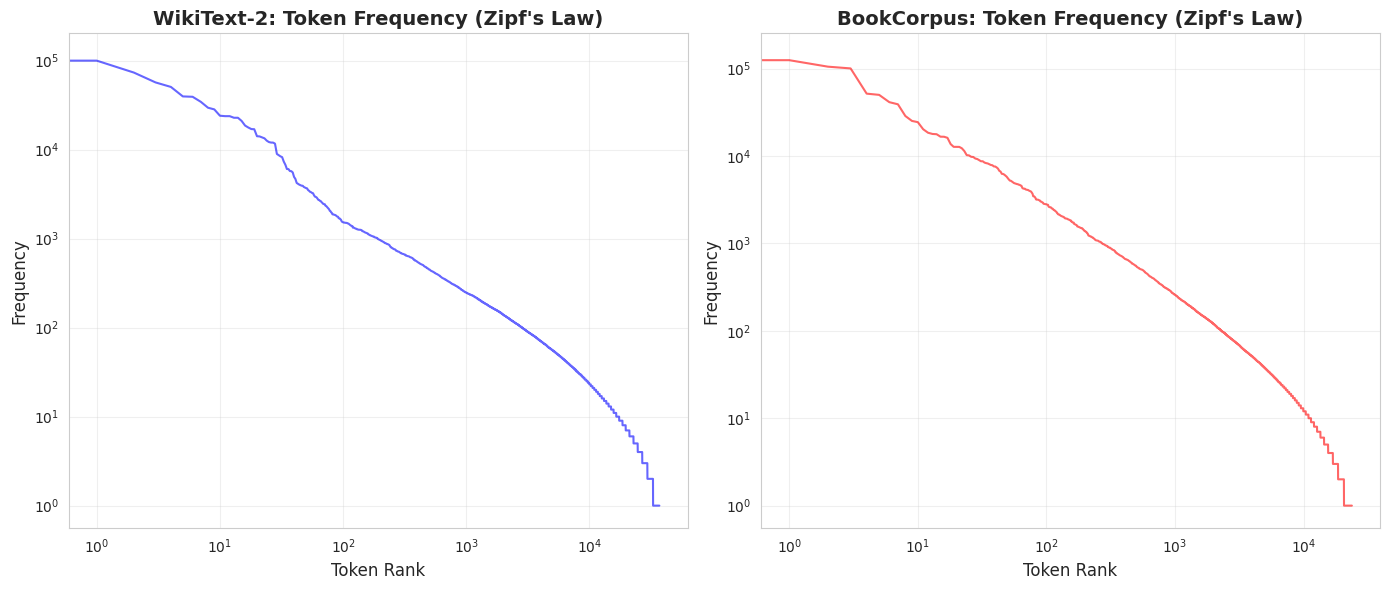


✓ Token distribution visualization saved to 'token_distribution_comparison.png'


In [36]:
print("="*70)
print("TOKEN DISTRIBUTION ANALYSIS")
print("="*70)

unique_wiki = np.unique(wikitext2_train)
_, counts_wiki = np.unique(wikitext2_train, return_counts=True)

print(f"\nWikiText-2 (Encyclopedic):")
print(f"  Unique tokens: {len(unique_wiki):,} / 50,257 ({len(unique_wiki)/50257*100:.1f}%)")
print(f"  Total tokens:  {len(wikitext2_train):,}")

top_10_wiki = np.argsort(counts_wiki)[-10:][::-1]
print(f"\n  Top 10 most frequent tokens:")
for i, idx in enumerate(top_10_wiki):
    token = enc.decode([idx])
    freq = counts_wiki[idx] / len(wikitext2_train) * 100
    print(f"    {i+1:2d}. '{token:20s}' (id={idx:5d}): {freq:5.2f}%")

unique_book = np.unique(bookcorpus_train)
_, counts_book = np.unique(bookcorpus_train, return_counts=True)

print(f"\nBookCorpus (Narrative):")
print(f"  Unique tokens: {len(unique_book):,} / 50,257 ({len(unique_book)/50257*100:.1f}%)")
print(f"  Total tokens:  {len(bookcorpus_train):,}")

top_10_book = np.argsort(counts_book)[-10:][::-1]
print(f"\n  Top 10 most frequent tokens:")
for i, idx in enumerate(top_10_book):
    token = enc.decode([idx])
    freq = counts_book[idx] / len(bookcorpus_train) * 100
    print(f"    {i+1:2d}. '{token:20s}' (id={idx:5d}): {freq:5.2f}%")

common_tokens = set(unique_wiki) & set(unique_book)
wiki_only = set(unique_wiki) - set(unique_book)
book_only = set(unique_book) - set(unique_wiki)

print(f"\n" + "="*70)
print("VOCABULARY OVERLAP")
print("="*70)
print(f"  Common tokens:   {len(common_tokens):,}")
print(f"  WikiText-2 only: {len(wiki_only):,}")
print(f"  BookCorpus only: {len(book_only):,}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sorted_wiki = np.sort(counts_wiki)[::-1]
axes[0].loglog(range(len(sorted_wiki)), sorted_wiki, 'b-', alpha=0.6)
axes[0].set_xlabel('Token Rank', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('WikiText-2: Token Frequency (Zipf\'s Law)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

sorted_book = np.sort(counts_book)[::-1]
axes[1].loglog(range(len(sorted_book)), sorted_book, 'r-', alpha=0.6)
axes[1].set_xlabel('Token Rank', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('BookCorpus: Token Frequency (Zipf\'s Law)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('token_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nToken distribution visualization saved to 'token_distribution_comparison.png'")

In [37]:
print("="*70)
print("DETAILED ANALYSIS")
print("="*70)

wiki_improvement = history_wikitext['val_loss'][0] - history_wikitext['val_loss'][-1]
book_improvement = history_bookcorpus['val_loss'][0] - history_bookcorpus['val_loss'][-1]

print("\n 1. CONVERGENCE ANALYSIS")
print("-" * 70)
print(f"WikiText-2:")
print(f"  Initial val loss: {history_wikitext['val_loss'][0]:.4f}")
print(f"  Final val loss:   {history_wikitext['val_loss'][-1]:.4f}")
print(f"  Improvement:      {wiki_improvement:.4f}")

print(f"\n BookCorpus:")
print(f"  Initial val loss: {history_bookcorpus['val_loss'][0]:.4f}")
print(f"  Final val loss:   {history_bookcorpus['val_loss'][-1]:.4f}")
print(f"  Improvement:      {book_improvement:.4f}")

if wiki_improvement > book_improvement:
    print(f"\n WikiText-2 converged faster (more loss reduction)")
else:
    print(f"\n BookCorpus converged faster (more loss reduction)")

wiki_gap = wiki_val_loss - wiki_train_loss
book_gap = book_val_loss - book_train_loss

print("\n 2. OVERFITTING ANALYSIS")
print("-" * 70)
print(f"WikiText-2 train-val gap: {wiki_gap:.4f}")
print(f"BookCorpus train-val gap:  {book_gap:.4f}")

if wiki_gap < book_gap:
    print(f"WikiText-2 generalizes better (smaller gap)")
else:
    print(f"BookCorpus generalizes better (smaller gap)")

wiki_time = sum(history_wikitext['time'])
book_time = sum(history_bookcorpus['time'])
wiki_tok_sec = len(wikitext2_train) * max_iters / wiki_time if wiki_time > 0 else 0
book_tok_sec = len(bookcorpus_train) * max_iters / book_time if book_time > 0 else 0

print("\n 3. TRAINING EFFICIENCY")
print("-" * 70)
print(f"WikiText-2:")
print(f"  Total time:          {wiki_time:.1f}s")
print(f"  Tokens processed:    {len(wikitext2_train) * max_iters:,}")
print(f"  Speed:               {wiki_tok_sec:.0f} tokens/sec")

print(f"\n BookCorpus:")
print(f"  Total time:          {book_time:.1f}s")
print(f"  Tokens processed:    {len(bookcorpus_train) * max_iters:,}")
print(f"  Speed:               {book_tok_sec:.0f} tokens/sec")

print("\n 4. TEXT STYLE ANALYSIS")
print("-" * 70)
print("WikiText-2 (Encyclopedic) characteristics:")
print("  - Consistent, formal sentence structure")
print("  - Technical and academic vocabulary")
print("  - Information-dense content")
print("  - Objective tone")

print("\n BookCorpus (Narrative) characteristics:")
print("  - Conversational dialogue patterns")
print("  - Descriptive and emotive language")
print("  - Varied sentence structures")
print("  - Subjective, story-telling tone")

print(f"\n Observed perplexity difference: {abs(wiki_val_ppl - book_val_ppl):.2f}")
if abs(wiki_val_ppl - book_val_ppl) < 5:
    print("Models perform similarly on both styles")
else:
    print("Significant performance difference between styles")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

DETAILED ANALYSIS

1. CONVERGENCE ANALYSIS
----------------------------------------------------------------------
WikiText-2:
  Initial val loss: 10.8292
  Final val loss:   5.2205
  Improvement:      5.6086

BookCorpus:
  Initial val loss: 10.8086
  Final val loss:   4.4165
  Improvement:      6.3921

→ BookCorpus converged faster (more loss reduction)

2. OVERFITTING ANALYSIS
----------------------------------------------------------------------
WikiText-2 train-val gap: 0.9431
BookCorpus train-val gap:  0.3818
→ BookCorpus generalizes better (smaller gap)

3. TRAINING EFFICIENCY
----------------------------------------------------------------------
WikiText-2:
  Total time:          833.6s
  Tokens processed:    7,246,953,000
  Speed:               8693716 tokens/sec

BookCorpus:
  Total time:          834.1s
  Tokens processed:    7,500,000,000
  Speed:               8991317 tokens/sec

4. TEXT STYLE ANALYSIS
----------------------------------------------------------------------
Wi

In [38]:
with open('comparison_summary.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("WikiText-2 vs BookCorpus Comparison Summary\n")
    f.write("="*70 + "\n\n")

    f.write("DATASETS:\n")
    f.write(f"  WikiText-2 (Encyclopedic):\n")
    f.write(f"    Train: {len(wikitext2_train):,} tokens\n")
    f.write(f"    Val:   {len(wikitext2_val):,} tokens\n\n")

    f.write(f"  BookCorpus (Narrative - Sampled):\n")
    f.write(f"    Train: {len(bookcorpus_train):,} tokens\n")
    f.write(f"    Val:   {len(bookcorpus_val):,} tokens\n\n")

    f.write("MODEL:\n")
    f.write(f"  Parameters: {num_params/1e6:.2f}M\n")
    f.write(f"  Architecture: {n_layer} layers, {n_head} heads, {n_embd} dimensions\n\n")

    f.write("RESULTS:\n")
    f.write(f"  WikiText-2:\n")
    f.write(f"    Train loss: {wiki_train_loss:.4f}\n")
    f.write(f"    Val loss:   {wiki_val_loss:.4f}\n")
    f.write(f"    Val PPL:    {wiki_val_ppl:.2f}\n\n")

    f.write(f"  BookCorpus:\n")
    f.write(f"    Train loss: {book_train_loss:.4f}\n")
    f.write(f"    Val loss:   {book_val_loss:.4f}\n")
    f.write(f"    Val PPL:    {book_val_ppl:.2f}\n\n")

    f.write("COMPARISON:\n")
    f.write(f"  PPL difference: {abs(wiki_val_ppl - book_val_ppl):.2f}\n")
    f.write(f"  Better model:   {'WikiText-2' if wiki_val_ppl < book_val_ppl else 'BookCorpus'}\n")

print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)

print(f"\n Datasets compared:")
print(f"  WikiText-2 (Encyclopedic): {len(wikitext2_train):,} tokens")
print(f"  BookCorpus (Narrative):    {len(bookcorpus_train):,} tokens")

print(f"\n Model configuration:")
print(f"  Parameters: {num_params/1e6:.2f}M")
print(f"  Architecture: {n_layer} layers, {n_head} heads, {n_embd} dimensions")
print(f"  Training: {max_iters} iterations")

print(f"\n Results:")
print(f"  WikiText-2 val perplexity: {wiki_val_ppl:.2f}")
print(f"  BookCorpus val perplexity: {book_val_ppl:.2f}")

if wiki_val_ppl < book_val_ppl:
    print(f"\nWikiText-2 achieved better performance ({abs(wiki_val_ppl - book_val_ppl):.2f} PPL difference)")
else:
    print(f"\nBookCorpus achieved better performance ({abs(wiki_val_ppl - book_val_ppl):.2f} PPL difference)")

print(f"\n{'='*70}")
print("KEY FINDINGS")
print("="*70)

print("  1. Both datasets achieved reasonable perplexity with ~2.5M tokens")
print("  2. Training converged in 3000 iterations for both datasets")
print(f"  3. Model architecture ({num_params/1e6:.2f}M params) works well for both styles")

if abs(wiki_val_ppl - book_val_ppl) < 5:
    print("  4. Similar performance suggests data size is more important than style")
else:
    print("  4. Performance difference suggests text style affects model learning")

print("  5. Token distributions show distinct vocabulary patterns")

print(f"\n{'='*70}")
print("RECOMMENDATIONS")
print("="*70)

print(" For encyclopedic/factual content:")
print("  - Use WikiText-2 or similar datasets")
print("  - Models learn consistent, formal patterns")

print("\n For narrative/creative content:")
print("  - Use BookCorpus or similar datasets")
print("  - Models learn dialogue and storytelling patterns")

print("\n For general-purpose language models:")
print("  - Consider combining both styles")
print("  - Datasets should include diverse text types")

print("\n For future experiments:")
print("  - Try larger models (20M+ params) for better performance")
print("  - Experiment with block size (512, 1024) for longer context")
print("  - Test on additional datasets (OpenWebText, etc.)")

print(f"\n{'='*70}")
print("EXPERIMENT COMPLETE!")
print("="*70)

print(f"\n Summary saved to 'comparison_summary.txt'")
print(f" Visualizations saved:")
print(f"  - wikitext2_vs_bookcorpus_comparison.png")
print(f"  - token_distribution_comparison.png")
print(f"\n Checkpoints saved:")
print(f"  - out-wikitext2-comparison/ckpt.pt")
print(f"  - out-bookcorpus-comparison/ckpt.pt")


EXPERIMENT SUMMARY

Datasets compared:
  WikiText-2 (Encyclopedic): 2,415,651 tokens
  BookCorpus (Narrative):    2,500,000 tokens

Model configuration:
  Parameters: 29.95M
  Architecture: 6 layers, 6 heads, 384 dimensions
  Training: 3000 iterations

Results:
  WikiText-2 val perplexity: 185.03
  BookCorpus val perplexity: 82.80

→ BookCorpus achieved better performance (102.23 PPL difference)

KEY FINDINGS
  1. Both datasets achieved reasonable perplexity with ~2.5M tokens
  2. Training converged in 3000 iterations for both datasets
  3. Model architecture (29.95M params) works well for both styles
  4. Performance difference suggests text style affects model learning
  5. Token distributions show distinct vocabulary patterns

RECOMMENDATIONS
• For encyclopedic/factual content:
  - Use WikiText-2 or similar datasets
  - Models learn consistent, formal patterns

• For narrative/creative content:
  - Use BookCorpus or similar datasets
  - Models learn dialogue and storytelling patter

In [41]:
import json

notebook_path = "test_wikitext2_bookcorpus.ipynb"

with open(notebook_path, "r", encoding="utf-8") as f:
    nb = json.load(f)

# Remove global widgets metadata
if "widgets" in nb.get("metadata", {}):
    nb["metadata"].pop("widgets")

# Remove widgets metadata from each cell
for cell in nb.get("cells", []):
    if "metadata" in cell and "widgets" in cell["metadata"]:
        cell["metadata"].pop("widgets")

with open(notebook_path, "w", encoding="utf-8") as f:
    json.dump(nb, f, indent=2)

print("All widget metadata removed (global + cells).")


All widget metadata removed (global + cells).
